In [107]:
import pandas as pd
import numpy as np
import os, os.path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import sklearn
from sklearn.mertrics import classification_report, confusion_matrix

num_classes = 17
img_size = 32 
batch_size = 8

train_data_dir = './17_flowers/train'
test_data_dir = './17_flowers/validation'

#To identify the number of files in the directory
# list = os.listdir(train_data_dir + '/daisy')
# num_files = len(list)
# print (num_files)

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
    rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    class_mode = 'categorical')


ModuleNotFoundError: No module named 'sklearn.mertrics'

## Model from scratch

In [66]:
def create_model_from_scratch():
    
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), padding = 'same', input_shape = (img_size, img_size, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
#     model.add(Dropout(0.5))
    
    model.add(Conv2D(64, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
     
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    
    print(model.summary())
    
    return model

In [67]:
scratch_model = create_model_from_scratch()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_148 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_133 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_149 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_134 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 32)      

## Training the model


In [68]:
nb_train_samples = 1190 
nb_validation_samples = 170 
epochs = 5

checkpoint = ModelCheckpoint("/home/deeplearningcv/Practice Projects/Flower Classifier/classified_flowers_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

scratch_model.compile(loss = 'categorical_crossentropy',
             optimizer = Adam(lr = 0.001),
             metrics = ['accuracy'])

history = scratch_model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size
)

print('Test Loss: ', scores[0])
print('Test Accuracy: ', scores[1])

Epoch 1/5
148/148 [==============================] - 30s 203ms/step - loss: 3.2000 - accuracy: 0.1523 - val_loss: 5.2639 - val_accuracy: 0.0595
Epoch 2/5
148/148 [==============================] - 23s 154ms/step - loss: 2.6770 - accuracy: 0.2073 - val_loss: 4.2569 - val_accuracy: 0.1296
Epoch 3/5
148/148 [==============================] - 22s 145ms/step - loss: 2.4850 - accuracy: 0.2225 - val_loss: 2.2626 - val_accuracy: 0.2407
Epoch 4/5
148/148 [==============================] - 23s 153ms/step - loss: 2.3383 - accuracy: 0.2707 - val_loss: 1.6673 - val_accuracy: 0.3025
Epoch 5/5
148/148 [==============================] - 28s 188ms/step - loss: 2.1242 - accuracy: 0.3139 - val_loss: 1.7604 - val_accuracy: 0.3519


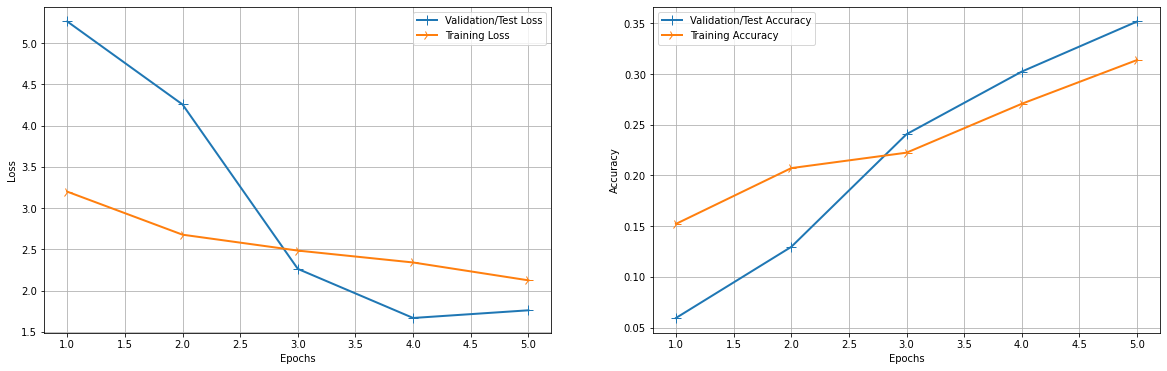

<Figure size 432x288 with 0 Axes>

In [105]:

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.subplot(1,2,2)
line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

plt.tight_layout()


## Performance Analysis
